In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,SimpleRNN,Flatten,Lambda,Conv1D,MaxPooling1D,BatchNormalization,Activation,Concatenate,Input,Add,Conv2D
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

In [ ]:
class timeSeriesPredict:
  def __init__(self,countryName):
    self.country = countryName
  series = []
  model = 0
  x = []
  y = []
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  split_time = 0
  lr = .001
  optimizer = Adam(lr)
  loss = tf.keras.losses.MeanSquaredError()
  callbacks = []
  epochs = 500
  history = None


In [ ]:
def get_series(file_path):
  sdate = datetime.datetime.strptime(starting_date, "%d%m%Y").date()
  with open(file_path) as f:
    reader = csv.reader(f,delimiter=',')
    next(reader)
    series = []
    c = 0
    dates = []
    for i in reader:
      try : 
        tmp = []
        tmp.append(float(i[5]))
        tmp.append(float(i[8]))
        series.append(np.array(tmp))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
      except:
        series.append(np.array([0,0]))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
        continue
    series = np.vstack(series)
    return series,dates



def create_windowed_dataset(series, window,begin):
  # series is a numpy array with shape (m,n_features)
  # this function returns x and y
  # x -> windowed data, numpy array of shape (m,n_features)
  # y -> labels for x, numpy array with shape(m,)
  m, n_features = series.shape
  i = begin
  x = []
  y = []
  while i < m :
    tmp = np.zeros((window,n_features))
    j = 0 if i-window >= 0 else window - i;
    tmp[j:window,:] = series[max(0,i-window):i,:] 
    x.append(tmp)
    y.append(series[i])
    i += 1
  return np.array(x), np.array(y)

def train_test_split(ratio,x,y):
  split_time = int(x.shape[0] * ratio)
  return x[0:split_time,:],x[split_time:,:],y[0:split_time],y[split_time:]

def moving_average(series,window):
  x = []
  m = series.shape[0]
  for i in range(m):
    b = i - window//2
    e = i + window//2
    inc = 0 if b > 0 else -b
    e += inc
    b += inc
    dec = 0 if e < m else e-m+1
    b -= dec
    e -= dec
    # print(b,e)
    # print(np.sum(series[b:e+1,:],axis=0))
    x.append(np.sum(series[b:e+1,:],axis=0) / window)
  return np.array(x) 

def plot(series,dates,fig=(5,3),label=None,title=None,interval=10,rotation=30,xlabel="Time",ylabel="New Cases"):
  fig = plt.figure(figsize = fig)
  ax = fig.add_subplot(111)
  plt.style.use("fivethirtyeight")

  n_lines = 2
  diff_linewidth = 1.05
  alpha_value = 0.1
  i = 0

  if dates != None:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.plot(dates,series,label = label,color='#00008B')
    
  else:
    ax.plot([*range(1,len(series)+1)],series,label = label,color='#00008B')
 
  for column in (series):
    ax.fill_between(x=i if dates==None else dates[i],
                    y1=column,
                    y2=[0] * len(series),
                    color='#00008B',
                    alpha=0.2)
    i=i+1
  

  
 # ax.plot(series,label = label,color='#FE53BB')
  ax.grid(color='#2A3459')
  ax.set_title(title,color='red')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  if label != None:
    ax.legend()
  plt.show()

def comp_plot(series1,series2,dates,figsize=(10,6),flabel='train',slabel='val',title=None,interval=10,rotation=30,pred=[]):

  
 # df.plot(marker='o', ax=ax, color=colors)

  plt.style.use("fivethirtyeight")
  
  


  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

  ax.grid(color='#2A3459')
  #ax.plot(series1,label = flabel)
  ax.plot(dates,series1,label = flabel,color='#00008B')
  



  
  z = dates+pred
  ax.plot(z,series2,label = slabel,color='#FFA500')
  
 
  i=0
  



  ax.set_xlabel('Time')
  ax.set_ylabel('New Cases')
  ax.set_title(title,color='red')
  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  #ax.legend()
  plt.legend(['True Cases','Predicted Cases'])

  plt.show()


def forecast(model,x,window,days,tmn,tstd):
  y = model.predict(x)
  print(y.shape)
  for i in range(days) : 
    m = y.shape[0]
    tmp = y[-window:m]
    tmp = np.expand_dims(tmp,[0])
    # print(tmp.shape)
    tmp = (tmp - tmn) / tstd
    y = np.append(y,model.predict(tmp),axis= 0)
  
  return y


def mape(y1,y2):
  
  error=0
  cnt=0
  for i in range(y1.shape[0]):
    if y1[i]!=0:
      error=error+np.abs(y1[i]-y2[i])/y1[i]
      cnt=cnt+1
  error=error/cnt
  #print(error)
  error=error*100
  #error=convert_to_tensor(error)

  return float(error)


def train_model(country):
  tf.keras.backend.clear_session()
  country.model.compile(loss=country.loss,metrics=['mse'],optimizer=country.optimizer)
  history = country.model.fit(x=country.x_train,y=country.y_train, validation_data = (country.x_val,country.y_val), epochs=country.epochs,verbose=1,batch_size=300,callbacks=country.callbacks)
  country.history = history
  # plot(history.history['mse'],None,fig=(12,6))
  # plot(history.history['val_mse'],None,fig=(12,6))
  

def show_plots(country):
  # plot(country.history.history['mse'],None,fig=(12,6),label='train_mse', title='train mse',xlabel="epochs",ylabel="mse")
  # plot(country.history.history['val_mse'],None,fig=(12,6), label='val_mse', title='val mse')
  y_actual=country.y
  y_predicted=country.model.predict(country.x)
  nRMSE_train=mean_squared_error(y_actual[:,0], y_predicted[:,0], squared=False)/np.mean(y_predicted[:,0])
  MAPE_train=mape(y_actual[:,0],y_predicted[:,0])
  comp_plot(country.y[:,0],country.model.predict(country.x)[:,0],country.dates,
            title='entire series prediction',interval=interval,rotation=rotation)
  
  y_actual=country.y_val
  y_predicted=country.model.predict(country.x_val)
  nRMSE_val=mean_squared_error(y_actual[:,0], y_predicted[:,0], squared=False)/np.mean(y_predicted[:,0])
  MAPE_val=mape(y_actual[:,0],y_predicted[:,0])
  comp_plot(country.y_val[:,0],country.model.predict(country.x_val)[:,0],country.dates[country.split_time:],
            title='Validation',interval=3,rotation=rotation)
  prediction_dates = []
  last = country.dates[-1];
  for i in range(1,41):
    prediction_dates.append(last+datetime.timedelta(days=i))
  comp_plot(country.y[:,0],forecast(country.model,country.x,window_size,40,0,1)[:,0],country.dates,
            figsize=(12,10),title='Forecast',interval=interval,rotation=rotation,pred=prediction_dates)
  return nRMSE_train,nRMSE_val,MAPE_train,MAPE_val


In [ ]:
ratio = .9
window_size = 20
n_features = 2
interval = 10
rotation = 45

In [ ]:
def get_model():
  model = tf.keras.Sequential([#Lambda(lambda x:tf.expand_dims(x,-1),input_shape=(window_size,n_features)),
                               #Conv2D(32,2,1,activation='relu'),
                               #Lambda(lambda x:tf.squeeze(x,2)),
                               Conv1D(32,3,1,activation='relu',input_shape=(window_size,n_features)),
                               Conv1D(64,3,1,activation='relu'),
                               Conv1D(128,3,1,activation='relu'),
                               Conv1D(256,3,1,activation='relu'),
                              #  Conv1D(512,3,1,activation='relu'),
                               Flatten(),
                              #  Dense(100),
                               Dense(10),
                               Dense(2)
  ])
  return model

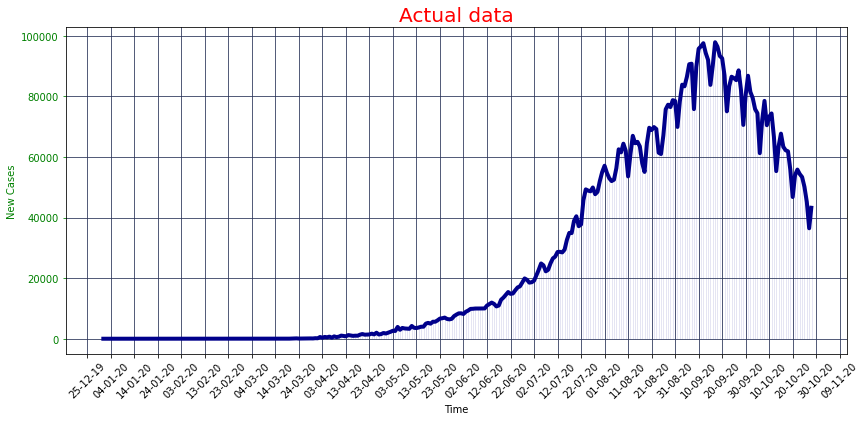

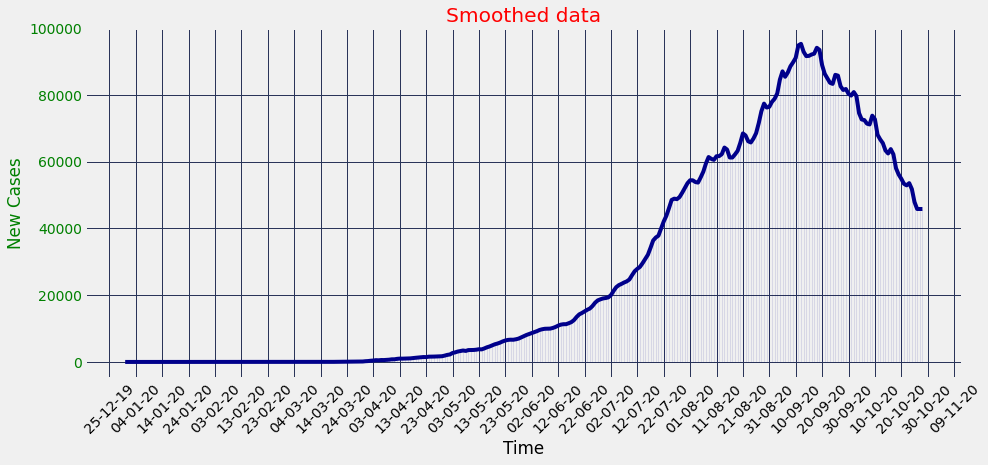

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
starting_date = "31122019"
india = timeSeriesPredict("india")
india.series,india.dates = get_series('/content/India.csv')
plot(india.series[:,0],india.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
india.series = moving_average(india.series,5)
plot(india.series[:,0],india.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
india.x,india.y = create_windowed_dataset(india.series,window_size,0)
india.x_train,india.x_val,india.y_train,india.y_val = train_test_split(ratio,india.x,india.y)
india.model = get_model()
india.model.summary()
india.epochs = 1000
india.split_time = int(india.x.shape[0] * ratio)

In [ ]:
train_model(india)

Epoch 1/1000
1/1 [==============================] - 0s 199ms/step - loss: 750690816.0000 - mse: 750690816.0000 - val_loss: 371715424.0000 - val_mse: 371715424.0000
Epoch 2/1000
1/1 [==============================] - 0s 24ms/step - loss: 224151552.0000 - mse: 224151552.0000 - val_loss: 245257776.0000 - val_mse: 245257776.0000
Epoch 3/1000
1/1 [==============================] - 0s 23ms/step - loss: 15219995.0000 - mse: 15219995.0000 - val_loss: 2357650176.0000 - val_mse: 2357650176.0000
Epoch 4/1000
1/1 [==============================] - 0s 26ms/step - loss: 220418192.0000 - mse: 220418192.0000 - val_loss: 1413395072.0000 - val_mse: 1413395072.0000
Epoch 5/1000
1/1 [==============================] - 0s 25ms/step - loss: 105912936.0000 - mse: 105912936.0000 - val_loss: 401219392.0000 - val_mse: 401219392.0000
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 15080054.0000 - mse: 15080054.0000 - val_loss: 43816184.0000 - val_mse: 43816184.0000
Epoch 7/1000
1/1 [=====

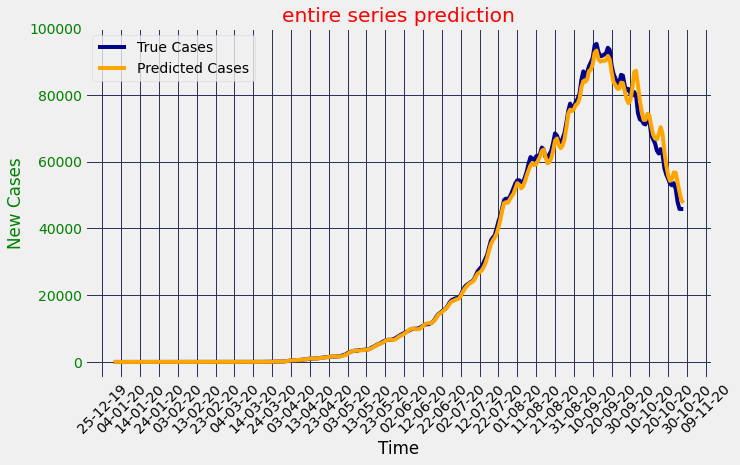

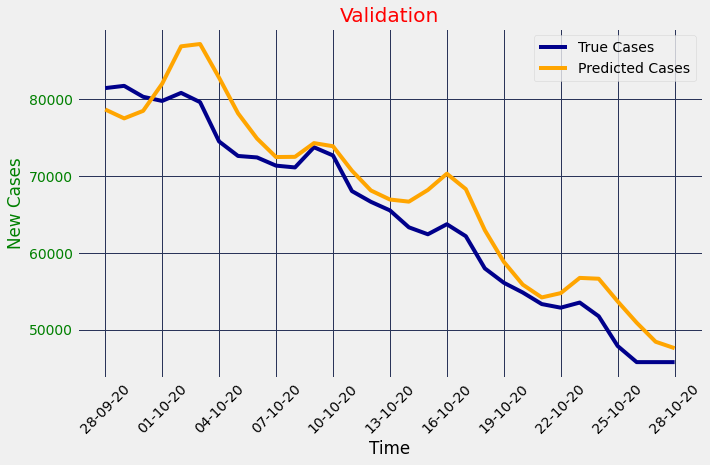

(303, 2)


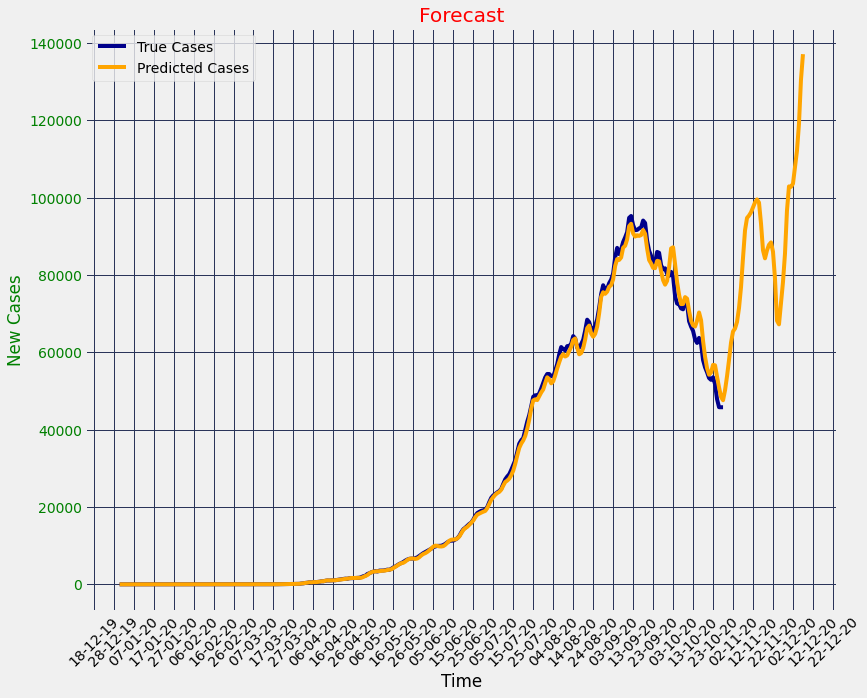

(0.0592389133399706, 0.0602578521114897, 11.791987025993473, 5.502566696182854)

In [ ]:
show_plots(india)

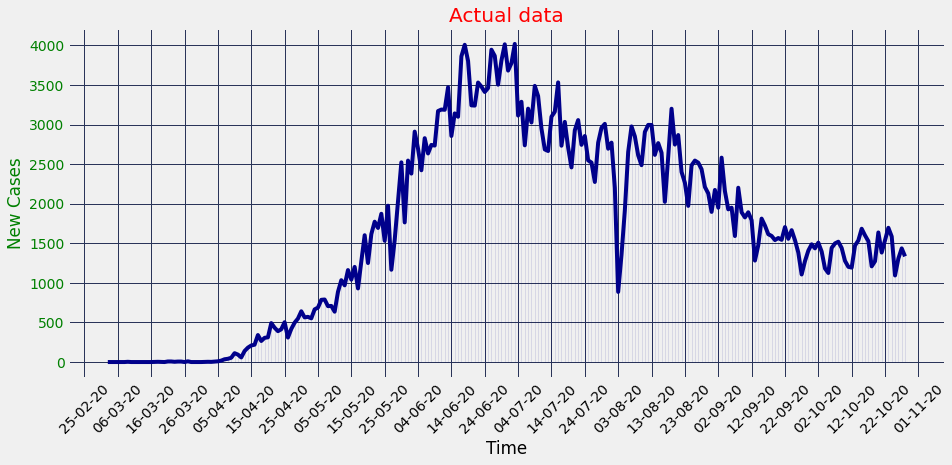

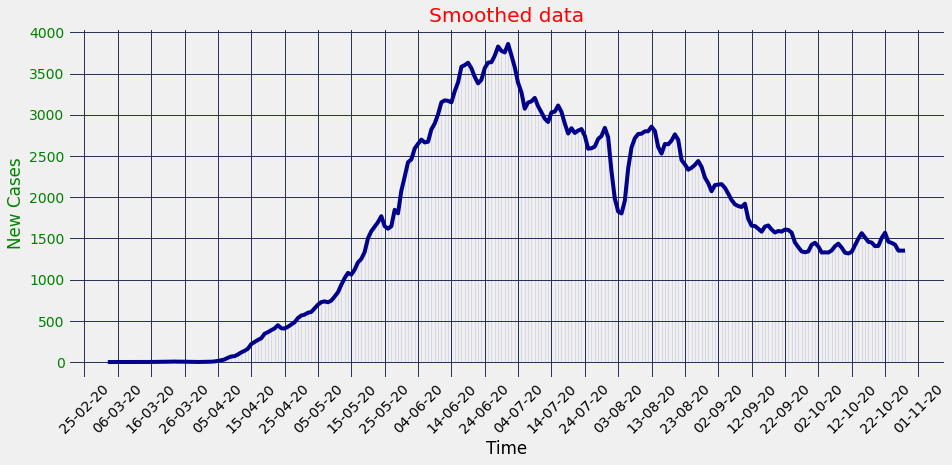

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
starting_date = "03032020"
bangladesh = timeSeriesPredict("Bangladesh")
country = bangladesh
country.series,country.dates = get_series('/content/Bangladesh.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 172ms/step - loss: 2517675.7500 - mse: 2517675.7500 - val_loss: 8254.5088 - val_mse: 8254.5088
Epoch 2/1000
1/1 [==============================] - 0s 24ms/step - loss: 86572.0391 - mse: 86572.0391 - val_loss: 952629.5000 - val_mse: 952629.5000
Epoch 3/1000
1/1 [==============================] - 0s 24ms/step - loss: 2133389.5000 - mse: 2133389.5000 - val_loss: 116941.8203 - val_mse: 116941.8203
Epoch 4/1000
1/1 [==============================] - 0s 25ms/step - loss: 300782.6562 - mse: 300782.6562 - val_loss: 347982.9062 - val_mse: 347982.9062
Epoch 5/1000
1/1 [==============================] - 0s 25ms/step - loss: 783878.6875 - mse: 783878.6875 - val_loss: 269701.5000 - val_mse: 269701.5000
Epoch 6/1000
1/1 [==============================] - 0s 27ms/step - loss: 626006.5625 - mse: 626006.5625 - val_loss: 113476.8438 - val_mse: 113476.8438
Epoch 7/1000
1/1 [==============================] - 0s 26ms/step - loss: 320887.7812 - mse: 320

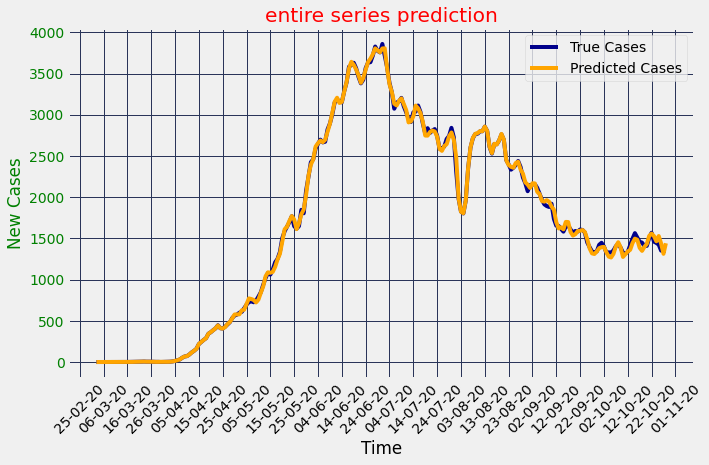

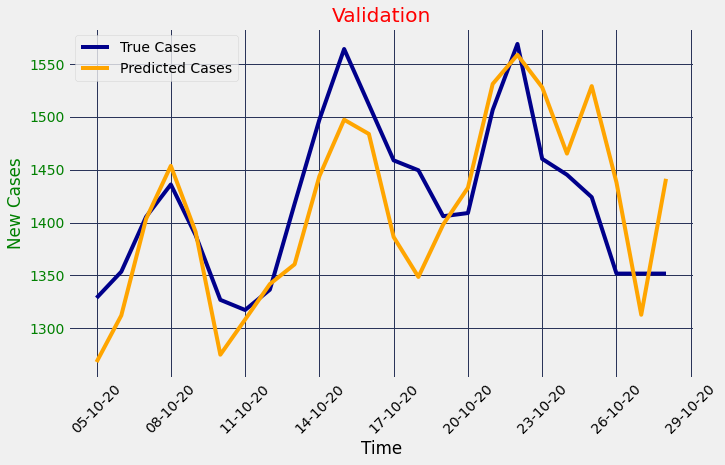

(240, 2)


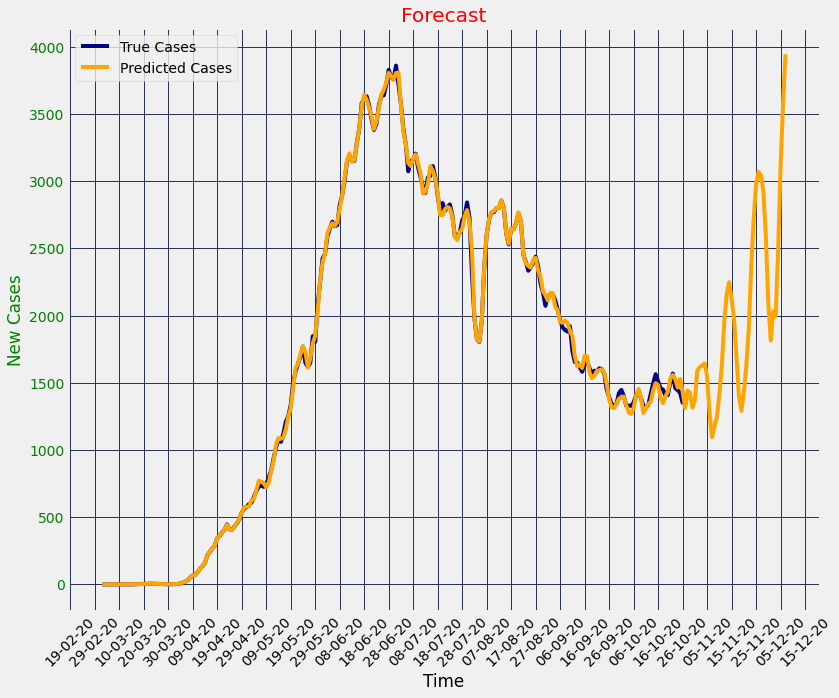

(0.019354577159894353,
 0.03809283563464333,
 2.3304059368737615,
 3.0669430579978156)

In [ ]:
show_plots(bangladesh)


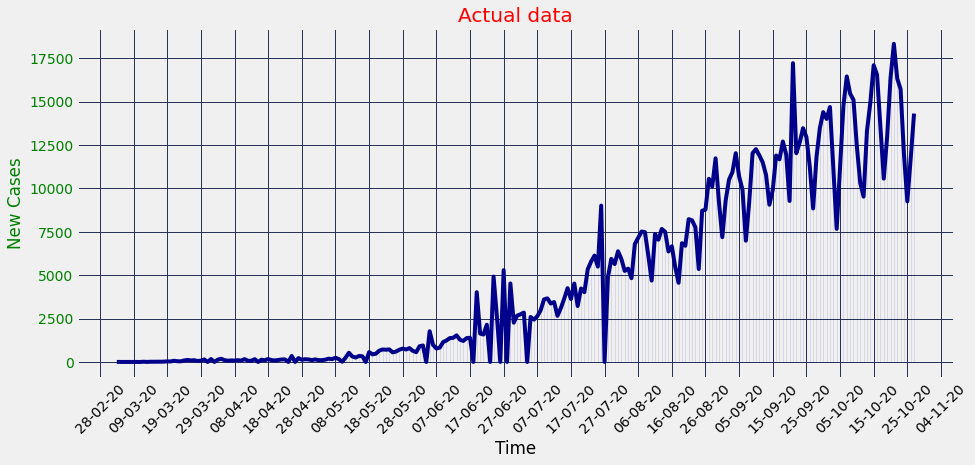

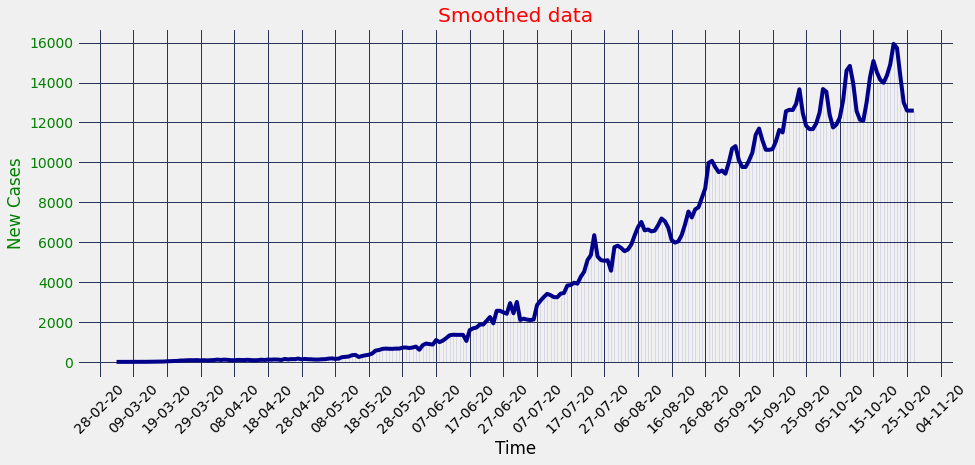

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
starting_date = "04032020"
argentina = timeSeriesPredict("Argentina")
country = argentina
country.series,country.dates = get_series('/content/Argentina.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(argentina)

Epoch 1/1000
1/1 [==============================] - 0s 161ms/step - loss: 16012562.0000 - mse: 16012562.0000 - val_loss: 3264221.7500 - val_mse: 3264221.7500
Epoch 2/1000
1/1 [==============================] - 0s 24ms/step - loss: 966266.0625 - mse: 966266.0625 - val_loss: 902920448.0000 - val_mse: 902920448.0000
Epoch 3/1000
1/1 [==============================] - 0s 24ms/step - loss: 114892688.0000 - mse: 114892688.0000 - val_loss: 1665739.8750 - val_mse: 1665739.8750
Epoch 4/1000
1/1 [==============================] - 0s 24ms/step - loss: 207670.8594 - mse: 207670.8594 - val_loss: 51332656.0000 - val_mse: 51332656.0000
Epoch 5/1000
1/1 [==============================] - 0s 24ms/step - loss: 9118603.0000 - mse: 9118603.0000 - val_loss: 78464984.0000 - val_mse: 78464984.0000
Epoch 6/1000
1/1 [==============================] - 0s 24ms/step - loss: 13258564.0000 - mse: 13258564.0000 - val_loss: 78096352.0000 - val_mse: 78096352.0000
Epoch 7/1000
1/1 [==============================] - 0s 

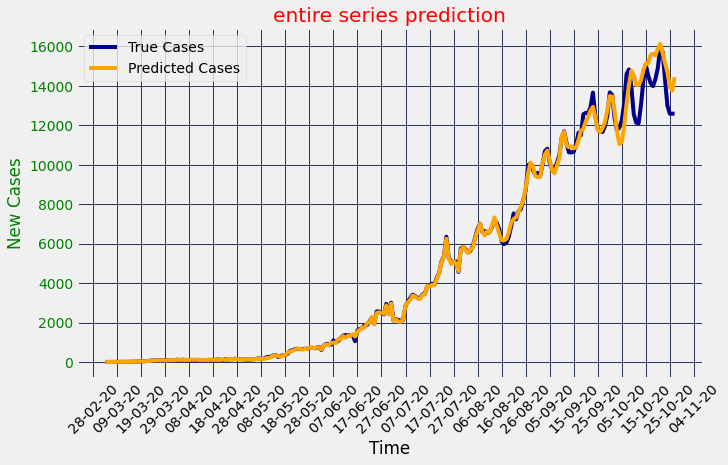

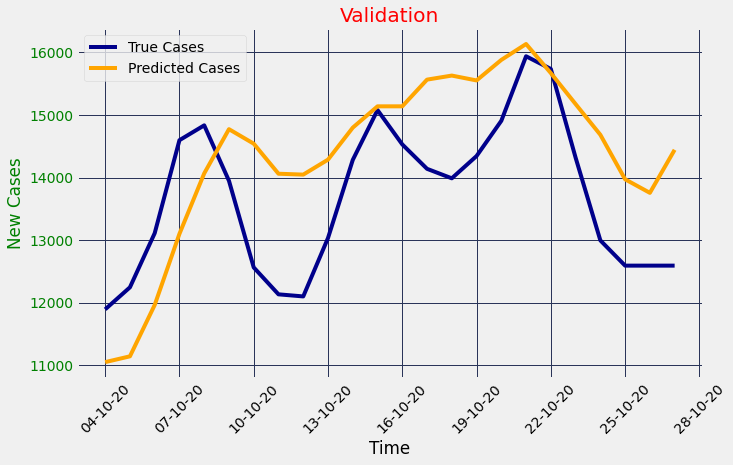

(238, 2)


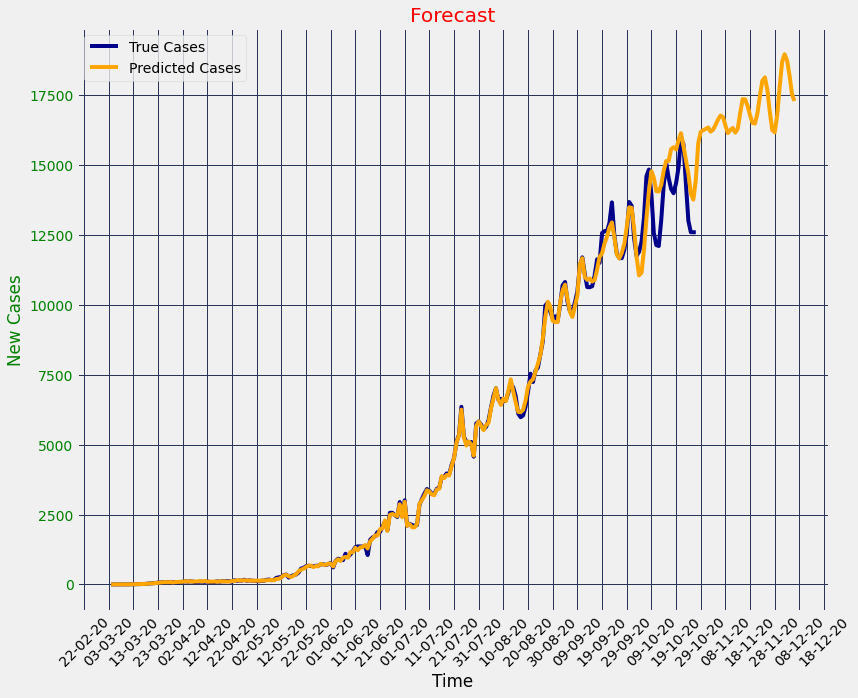

(0.0874187132523863, 0.08743537529361615, 5.518317894841594, 8.499535007252675)

In [ ]:
show_plots(argentina)

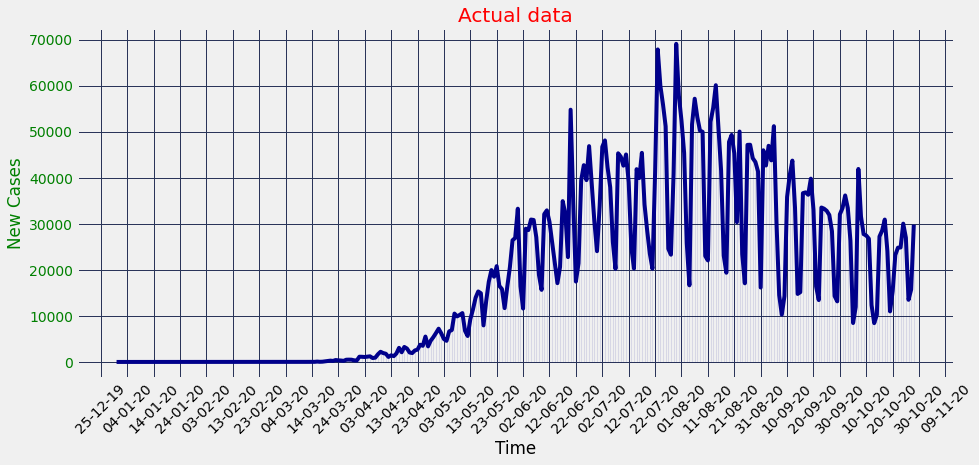

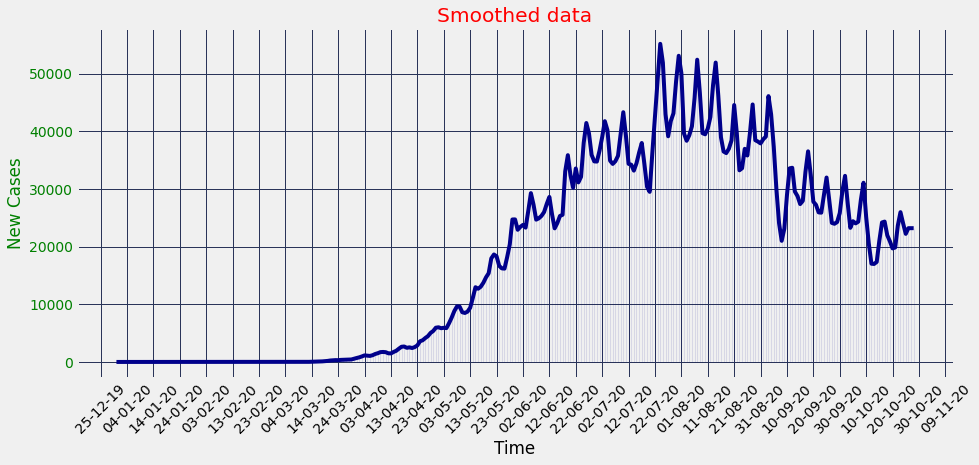

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
starting_date = "31122019"
brazil = timeSeriesPredict("Brazil")
country = brazil
country.series,country.dates = get_series('/content/Brazil.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 160ms/step - loss: 229611856.0000 - mse: 229611856.0000 - val_loss: 715126400.0000 - val_mse: 715126400.0000
Epoch 2/1000
1/1 [==============================] - 0s 23ms/step - loss: 533012896.0000 - mse: 533012896.0000 - val_loss: 60590156.0000 - val_mse: 60590156.0000
Epoch 3/1000
1/1 [==============================] - 0s 23ms/step - loss: 77697176.0000 - mse: 77697176.0000 - val_loss: 145991152.0000 - val_mse: 145991152.0000
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 162544880.0000 - mse: 162544880.0000 - val_loss: 90613368.0000 - val_mse: 90613368.0000
Epoch 5/1000
1/1 [==============================] - 0s 24ms/step - loss: 104926320.0000 - mse: 104926320.0000 - val_loss: 74532880.0000 - val_mse: 74532880.0000
Epoch 6/1000
1/1 [==============================] - 0s 25ms/step - loss: 49221916.0000 - mse: 49221916.0000 - val_loss: 50689556.0000 - val_mse: 50689556.0000
Epoch 7/1000
1/1 [===============

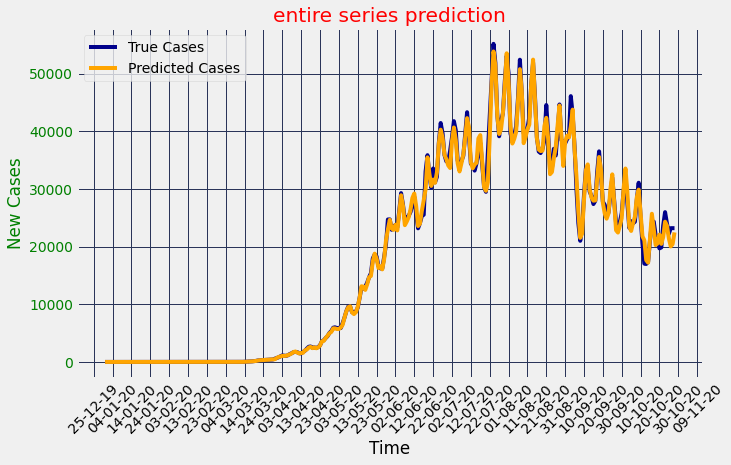

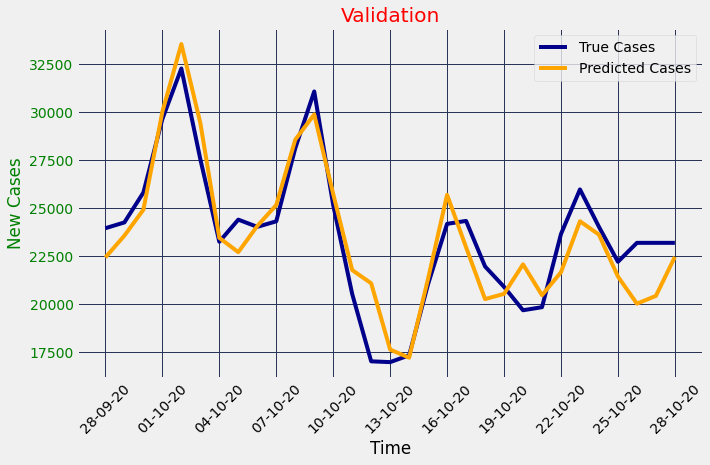

(303, 2)


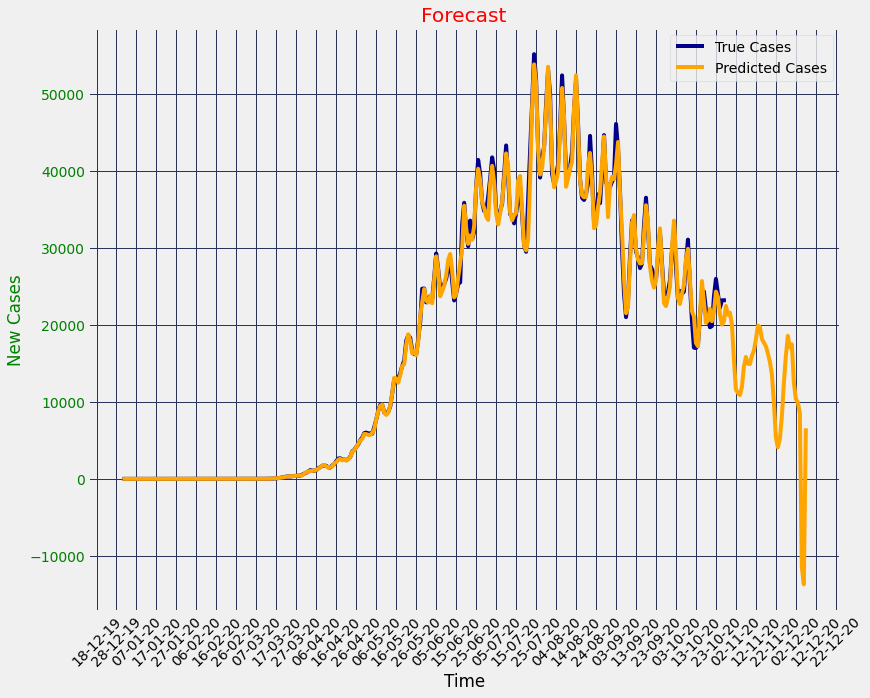

(0.05415931836674241,
 0.06480787965461472,
 16.727938496842253,
 5.320643860728637)

In [ ]:
show_plots(brazil)

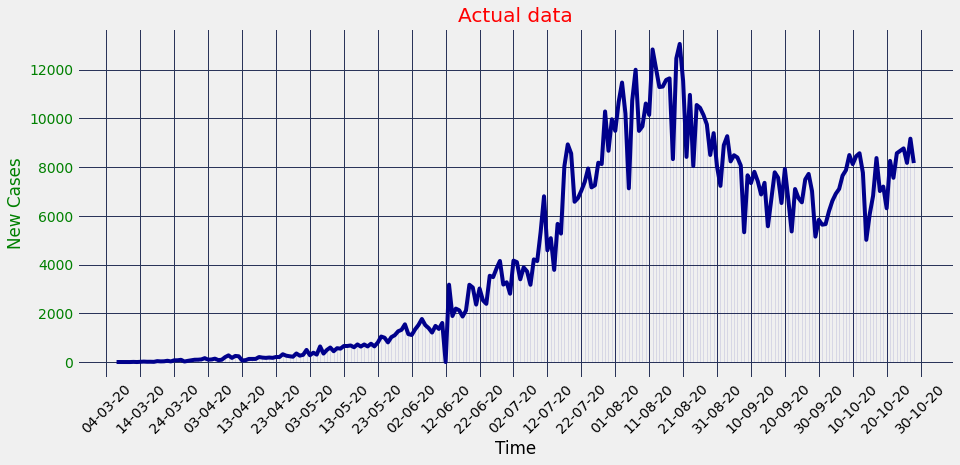

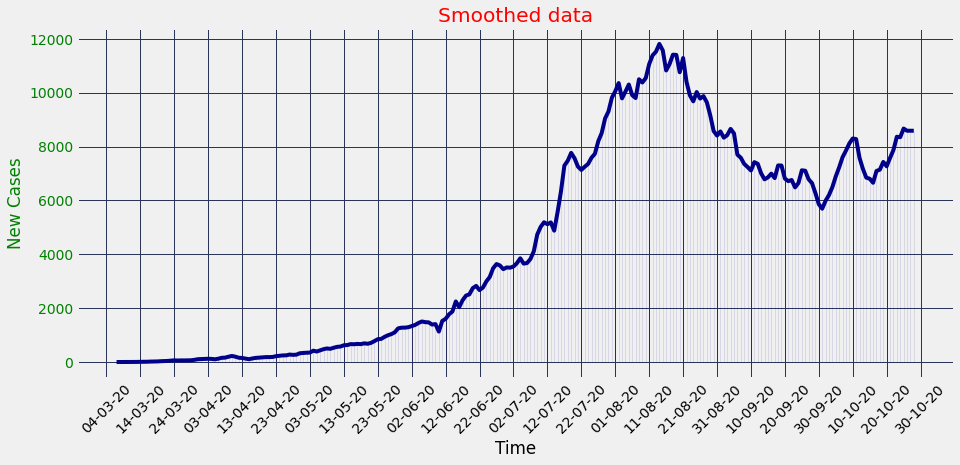

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
starting_date = "07032020"
colombia = timeSeriesPredict("Colombia")
country = colombia
country.series,country.dates = get_series('/content/Colombia.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 189ms/step - loss: 14513380.0000 - mse: 14513380.0000 - val_loss: 77067544.0000 - val_mse: 77067544.0000
Epoch 2/1000
1/1 [==============================] - 0s 29ms/step - loss: 49144928.0000 - mse: 49144928.0000 - val_loss: 9919417.0000 - val_mse: 9919417.0000
Epoch 3/1000
1/1 [==============================] - 0s 26ms/step - loss: 4864682.5000 - mse: 4864682.5000 - val_loss: 13415861.0000 - val_mse: 13415861.0000
Epoch 4/1000
1/1 [==============================] - 0s 29ms/step - loss: 6694422.5000 - mse: 6694422.5000 - val_loss: 1662118.6250 - val_mse: 1662118.6250
Epoch 5/1000
1/1 [==============================] - 0s 33ms/step - loss: 2063748.2500 - mse: 2063748.2500 - val_loss: 4051004.0000 - val_mse: 4051004.0000
Epoch 6/1000
1/1 [==============================] - 0s 31ms/step - loss: 2079823.3750 - mse: 2079823.3750 - val_loss: 263239.3750 - val_mse: 263239.3750
Epoch 7/1000
1/1 [==============================] - 0s 31ms/ste

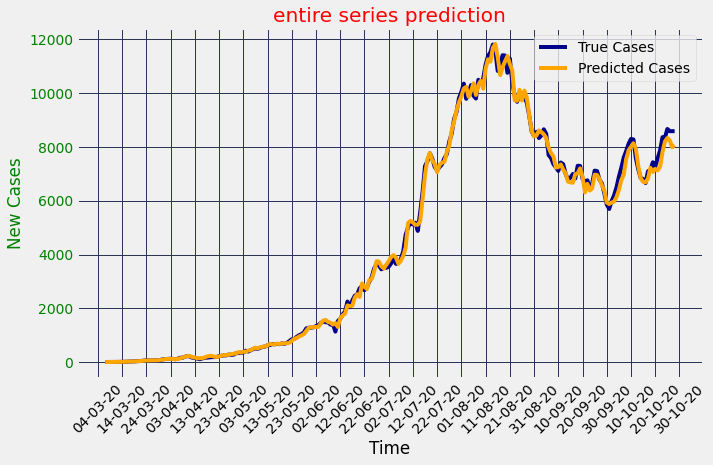

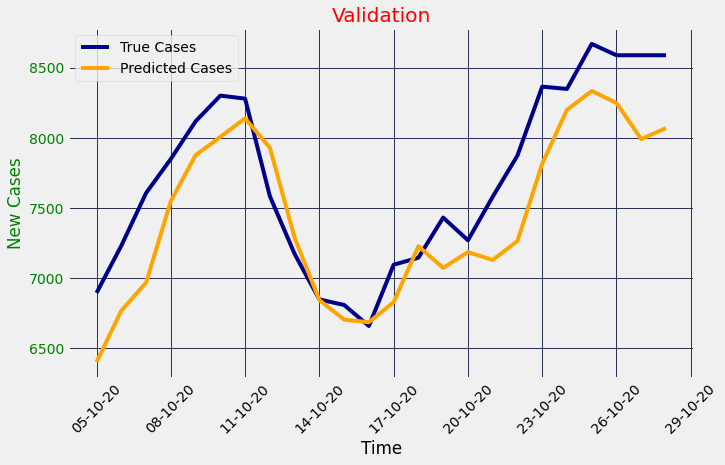

(236, 2)


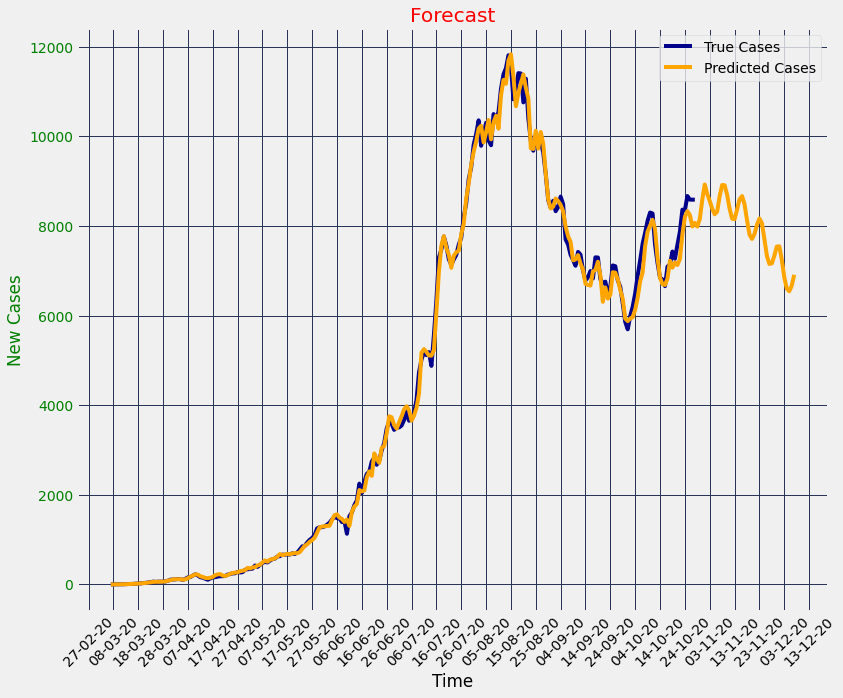

(0.04314731900279108,
 0.04938723208989141,
 6.274473826218946,
 4.000862243091529)

In [ ]:
show_plots(colombia)

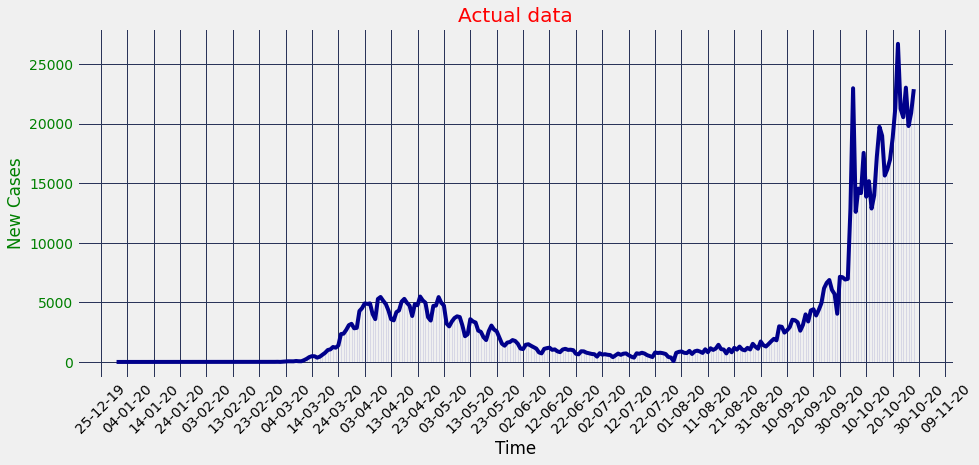

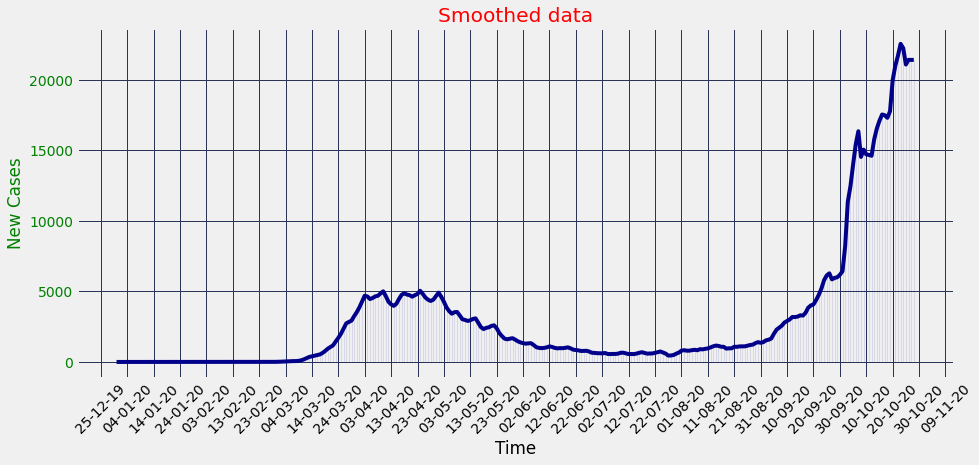

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
starting_date = "31122019"
uk = timeSeriesPredict("UK")
country = uk
country.series,country.dates = get_series('/content/United Kingdom.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 151ms/step - loss: 2736376.2500 - mse: 2736376.2500 - val_loss: 14201910.0000 - val_mse: 14201910.0000
Epoch 2/1000
1/1 [==============================] - 0s 24ms/step - loss: 448836.5938 - mse: 448836.5938 - val_loss: 11852381.0000 - val_mse: 11852381.0000
Epoch 3/1000
1/1 [==============================] - 0s 23ms/step - loss: 620485.3125 - mse: 620485.3125 - val_loss: 44066460.0000 - val_mse: 44066460.0000
Epoch 4/1000
1/1 [==============================] - 0s 25ms/step - loss: 777508.4375 - mse: 777508.4375 - val_loss: 12750737.0000 - val_mse: 12750737.0000
Epoch 5/1000
1/1 [==============================] - 0s 23ms/step - loss: 314162.0625 - mse: 314162.0625 - val_loss: 37027788.0000 - val_mse: 37027788.0000
Epoch 6/1000
1/1 [==============================] - 0s 26ms/step - loss: 1871329.5000 - mse: 1871329.5000 - val_loss: 24462894.0000 - val_mse: 24462894.0000
Epoch 7/1000
1/1 [==============================] - 0s 24ms/step 

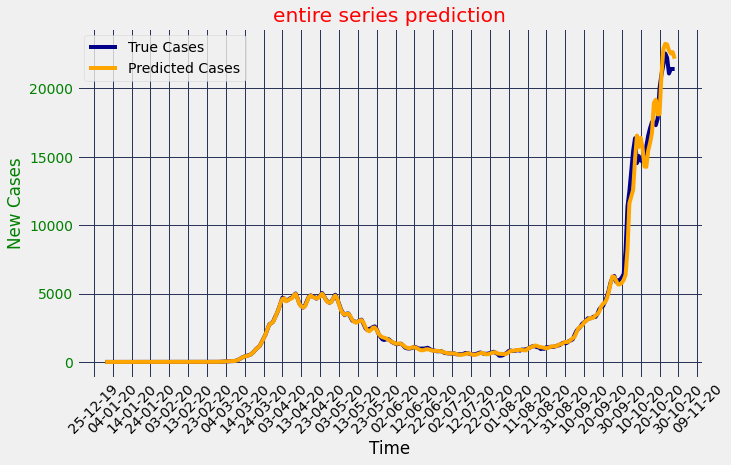

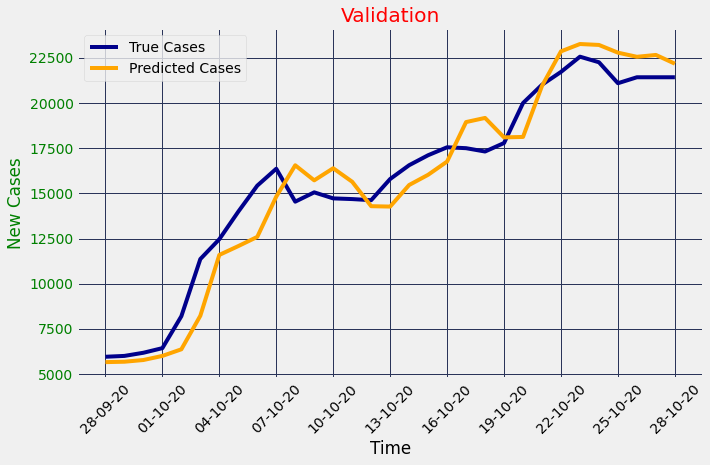

(303, 2)


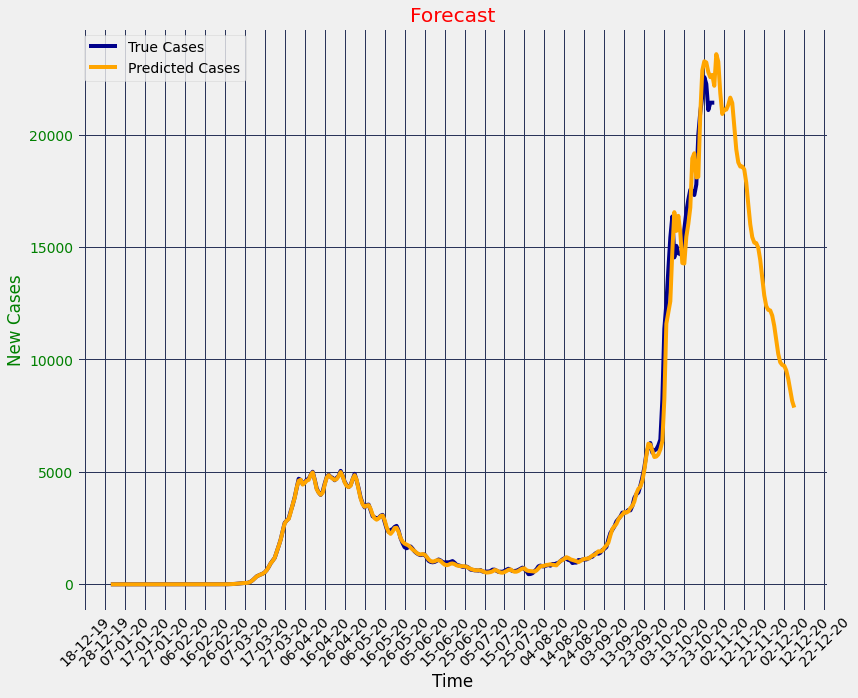

(0.14901622315024515,
 0.08915239956428801,
 14.481268543600686,
 8.159138110425209)

In [ ]:
show_plots(uk)

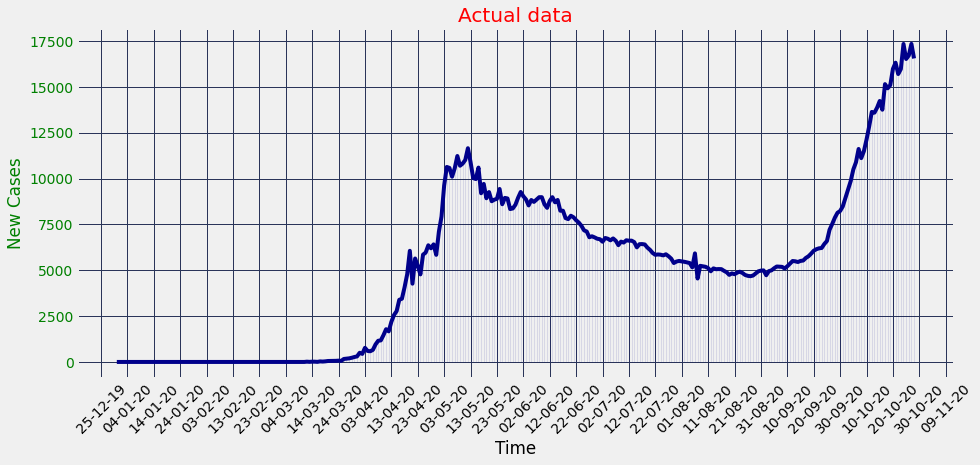

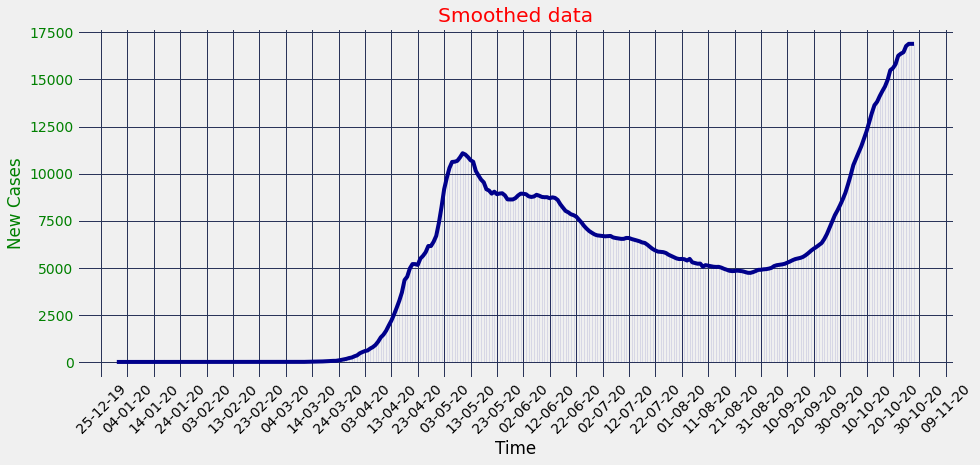

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           98560     
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
starting_date = "31122019"
russia = timeSeriesPredict("Russia")
country = russia
country.series,country.dates = get_series('/content/Russia.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 155ms/step - loss: 16566818.0000 - mse: 16566818.0000 - val_loss: 62092180.0000 - val_mse: 62092180.0000
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - loss: 22534140.0000 - mse: 22534140.0000 - val_loss: 20100410.0000 - val_mse: 20100410.0000
Epoch 3/1000
1/1 [==============================] - 0s 26ms/step - loss: 2162325.7500 - mse: 2162325.7500 - val_loss: 23794052.0000 - val_mse: 23794052.0000
Epoch 4/1000
1/1 [==============================] - 0s 27ms/step - loss: 3004170.7500 - mse: 3004170.7500 - val_loss: 1710844.6250 - val_mse: 1710844.6250
Epoch 5/1000
1/1 [==============================] - 0s 25ms/step - loss: 2013159.0000 - mse: 2013159.0000 - val_loss: 10597362.0000 - val_mse: 10597362.0000
Epoch 6/1000
1/1 [==============================] - 0s 24ms/step - loss: 1242784.3750 - mse: 1242784.3750 - val_loss: 13312878.0000 - val_mse: 13312878.0000
Epoch 7/1000
1/1 [==============================] - 0s 

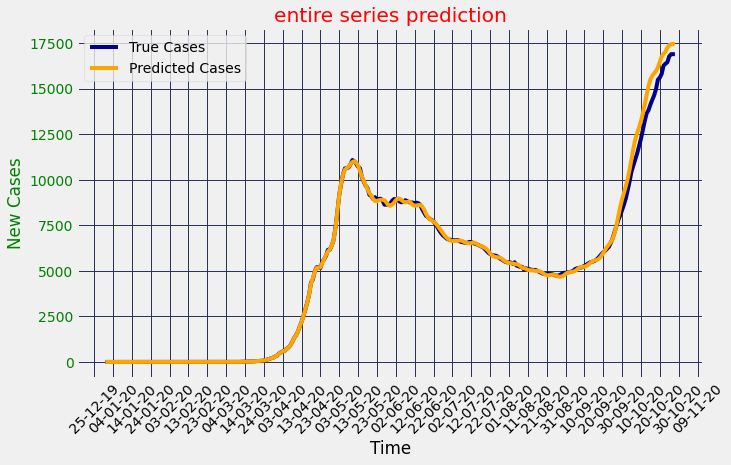

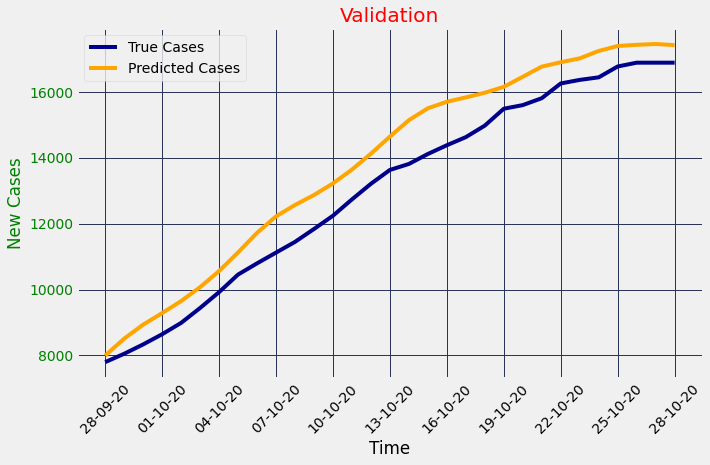

(303, 2)


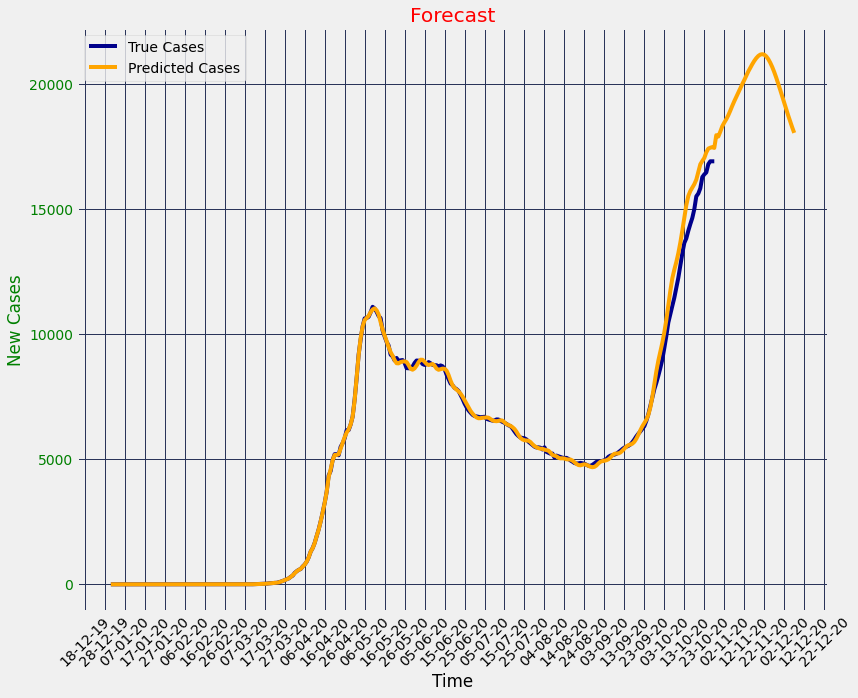

(0.05471727799607542,
 0.06287177195487764,
 4.7887792200035095,
 6.516647513287613)

In [ ]:
show_plots(russia)